# Efficient loops

We will now see how loops are handled in JAX. _... wait, loops? I thought JAX was all about vectorization!_ Yes, JAX is all about vectorization, but sometimes there are cases where you need to use loops. In this notebook, we will see how to write efficient loops in JAX.

Loops in JAX are handled through three primary functions, provided by the `jax.lax` module:
1. `lax.scan`
2. `lax.fori_loop`
3. `lax.while_loop`

We will see how to use each of these functions in this notebook.

## The problem

As an example problem, consider solving a model for exponential decay, given by
```{math}
    u'(t) = -a u(t), \quad u(0) = I, t \in (0, T]
```
where $a > 0$ is the decay rate, through a finite difference scheme.

Through _the unifying $\theta$-rule_ {cite}`LangtangenHansPetter2016FDCw`, we can discretize the above equation as
```{math}
    \frac{u^{n+1} - u^n}{t_{n+1} - t_n} = -a \left(\theta u^{n+1} + (1 - \theta) u^n \right),
```
where with $\theta = 0$ we have the explicit Euler method, with $\theta = 1$ we have the implicit Euler method, and with $\theta = \frac{1}{2}$ we have the Crank-Nicolson method.

Solving the above equation for $u^{n+1}$ with a constant timestep $\Delta t = t_{n+1} - t_n \ \forall n$, we get
```{math}
    u^{n+1} = \frac{1 - \left( 1 - \theta \right) a \Delta t}{1 + \theta a \Delta t} u^n.
```

## Implementing a solver in NumPy

Implementing a solver for the above equation is relatively simple in NumPy.

In [1]:
import numpy as np


def solver_numpy(
    I: float, a: float, T: float, dt: float, theta: float
) -> tuple[np.ndarray, np.ndarray]:
    num_steps = int(T // dt)
    u = np.zeros(num_steps + 1)
    t = np.linspace(0, num_steps * dt, num_steps + 1)

    u[0] = I
    for n in range(num_steps):
        u[n + 1] = (1 - (1 - theta) * a * dt) / (1 + theta * a * dt) * u[n]
    return u, t

Testing the solver with the Crank-Nicolson method, we have

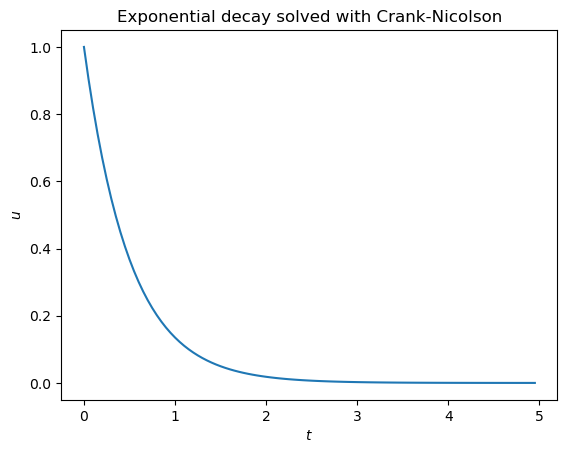

In [31]:
import matplotlib.pyplot as plt

I = 1
a = 2
T = 5
dt = 0.05
theta = 0.5

u, t = solver_numpy(I, a, T, dt, theta)
plt.plot(t, u)
plt.xlabel("$t$")
plt.ylabel("$u$")
plt.title("Exponential decay solved with Crank-Nicolson")
plt.show()

This implementation is however quite slow, as it uses a Python for-loop. In this case, we can speed up the implementation by noting that our reccurence relation can be written as
```{math}
    u^{n+1} = A u^n = A^n u^0,
```
where
```{math}
    A = \frac{1 - \left( 1 - \theta \right) a \Delta t}{1 + \theta a \Delta t}.
```

We can then use `np.cumprod` to calculate cumulative product of $A$ over the timesteps, getting rid of the (pure python) for-loop.

In [3]:
def solver_numpy_cumprod(
    I: float, a: float, T: float, dt: float, theta: float
) -> tuple[np.ndarray, np.ndarray]:
    num_steps = int(T // dt)
    u = np.zeros(num_steps + 1)
    t = np.linspace(0, num_steps * dt, num_steps + 1)

    u[0] = I
    A = (1 - (1 - theta) * a * dt) / (1 + theta * a * dt)
    u[1:] = A

    u = np.cumprod(u)
    return u, t

Comparing the two implementations, we see that the vectorized implementation is much faster.

In [4]:
%timeit solver_numpy(I, a, T, dt, theta)

26.3 μs ± 1.03 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [5]:
%timeit solver_numpy_cumprod(I, a, T, dt, theta)

6.87 μs ± 90.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


```{note}
This method of vectorizing is not always possible, and relies on the fact that the reccurence relation can be written with a common amplification factor $A$.
```

## Implementing a solver in JAX

Before we move on to the `lax` functions, let's see how we can implement the solver in JAX, as there are a few sharp edges to be aware of.

### Stumbling towards an implementation
The main thing is that JAX arrays are **immutable**. This means that you cannot change the value of an array in-place. Consider the following example:


In [6]:
import jax.numpy as jnp

u = jnp.array([1, 2, 3, 4, 5])

try:
    u[1] = 10
except TypeError as e:
    print(e)

JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


What we instead need to do, as the error message so helpfully suggests, is to use `u.at[1].set(10)` to set the value of the array at index 1 to 10.

Trying this, we see that we do not get an error.

In [7]:
u.at[1].set(10)

Array([ 1, 10,  3,  4,  5], dtype=int32)

This is however not an inplace operation, but rather a functional operation that returns a new array with the value at index 1 set to 10. **The original array is not changed.**

In [8]:
u

Array([1, 2, 3, 4, 5], dtype=int32)

This causes a lot of copy operations in JAX, which can be quite slow, as well as some pretty verbose syntax.

```{note}
Most of the time, changing the value of an array out-of-place is not a problem, as it is converted to in-place operations when possible by the jit compiler.
```

Implementing the solver with this in mind, we get the following implementation:

In [9]:
from jax import Array


def solver_jax(
    I: float, a: float, T: float, dt: float, theta: float
) -> tuple[Array, Array]:
    num_steps = int(T // dt)
    u = jnp.zeros(num_steps + 1)
    t = jnp.linspace(0, num_steps * dt, num_steps + 1)

    u = u.at[0].set(I)
    for n in range(num_steps):
        new_value = (1 - (1 - theta) * a * dt) / (1 + theta * a * dt) * u[n]
        u = u.at[n + 1].set(new_value)
    return u, t

Now, let's see if we have that famous JAX speedup!

In [10]:
%timeit solver_jax(I, a, T, dt, theta)

18.9 ms ± 179 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Wait, what? That was really slow! What happened?

Well, here we obviously forgot to use `jit` to compile the function. Let's try that again. Here we need to use the `static_argnums` argument to `jit`, as the number of iterations is dependent on $T$ and $\Delta t$, and which therefore need to be known at compile time.

In [11]:
from jax import jit

solver_jax_jitted = jit(solver_jax, static_argnums=(2, 3))

%timeit solver_jax_jitted(I, a, T, dt, theta)

20.1 μs ± 7.94 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Finally, we got a bit closer to that famous speed, although we are still a bit off. In order to get a deeper understanding of how this happened, we will consider a _highly_ simplified version of the problem.

In [12]:
def loop(I: float) -> float:
    for n in range(1, 6):
        I = n * I
    return I

In order to see what `jit` does, we will use the `jax.make_jaxpr` function to see the compiled expression.

In [13]:
import jax

jax.make_jaxpr(loop)(5)

{ lambda ; a:i32[]. let
    b:i32[] = mul 1 a
    c:i32[] = mul 2 b
    d:i32[] = mul 3 c
    e:i32[] = mul 4 d
    f:i32[] = mul 5 e
  in (f,) }

As we see, JAX has performed _loop unrolling_, in order to get rid of the overhead of the loop. This can sometimes be quite beneficial, however in our case, we have a large number of iterations, which causes the compilation in itself to be quite slow. In the case of our solver, doubling the number of iterations (in order to force recompilation) results in a compilation time of roughly 600 ms, which is not ideal for a function we might only call once.

In [14]:
%timeit -n 1 -r 1 jit(solver_jax, static_argnums=(2, 3))(I, a, T*2, dt, theta)

584 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The `cumprod` version of the solver is easily translated to JAX, and we see that it is much faster than the looped version.

In [21]:
def solver_jax_cumprod(
    I: float, a: float, T: float, dt: float, theta: float
) -> tuple[Array, Array]:
    num_steps = int(T // dt)
    u = jnp.zeros(num_steps + 1)
    t = jnp.linspace(0, num_steps * dt, num_steps + 1)

    u = u.at[0].set(I)
    A = (1 - (1 - theta) * a * dt) / (1 + theta * a * dt)
    u = u.at[1:].set(A)

    u = jnp.cumprod(u)
    return u, t

In [26]:
solver_jax_cumprod_jitted = jit(solver_jax_cumprod, static_argnums=(2, 3))

%timeit solver_jax_cumprod_jitted(I, a, T, dt, theta)

16.7 μs ± 283 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


This is however quite a bit slower than the NumPy version, which is a bit disappointing. The reason for this stems partly from the difference in where the majority of the focus has been placed in the two libraries. As NumPy does not have a JIT compiler, a great deal of effort has been put into optimizing per-call performance, as the overhead incurred cannot be avoided.

JAX on the other hand has been developed with a focus on multi-core and GPU acceleration, relying on the JIT compiler to optimize large chunks of code at the time.

As we are in effect benchmarking a single function call, `cumprod`, it is not surprising that NumPy is faster in this case.

### Using `lax.fori_loop`

As our original implementation in JAX was quite slow, we will use the control flow primitives provided by `lax` to speed up our implementation.

As the original solver was a simple for-loop, we will naturally use `lax.fori_loop` to implement the solver.

`lax.fori_loop` is roughly equivalent to the follow code snippet:
```python
def fori_loop(start, stop, body_fun, init_val):
    val = init_val
    for i in range(start, stop):
        val = body_fun(i, val)
    return val
```
where we have a start index, a stop index, a body function, and an initial value. `body_fun` is typically where all the heavy lifting is done, as we soon will see.

As we've seen previously, we can use `@jit` as a dectorator to compile the function. However, now that we need to specify the `static_argnums` argument, we need to use a little trick to get the function to compile. This trick is to use `functools.partial` to specify the `static_argnums` argument.

In [15]:
from jax import lax
from functools import partial


@partial(jit, static_argnums=(2, 3))
def solver_jax_fori(
    I: float, a: float, T: float, dt: float, theta: float
) -> tuple[Array, Array]:
    num_steps = int(T // dt)
    t = jnp.linspace(0, num_steps * dt, num_steps + 1)

    u = jnp.zeros(num_steps + 1)
    u = u.at[0].set(I)

    def body_fun(n: int, u: Array) -> Array:
        u_next = (1 - (1 - theta) * a * dt) / (1 + theta * a * dt) * u[n]
        u = u.at[n + 1].set(u_next)
        return u

    u = lax.fori_loop(0, num_steps, body_fun, u)
    return u, t

Timing the function, we see that we have a significant speedup compared to the previous implementation.

In [27]:
%timeit -n 1 -r 1 solver_jax_fori(I, a, T*2, dt, theta)

55.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


We are also now outperfoming the first NumPy implementation, which is quite nice.

In [28]:
%timeit solver_jax_fori(I, a, T, dt, theta)

13.3 μs ± 18.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Using `lax.scan`

In the example problem considered here, we are solving a simple ODE, where the solution at the next timestep is dependent on the solution at the previous timestep. With the previous implementation, we only used the index variable `n` to retrieve the solution at the previous timestep. A more natural way to implement this would be to use `lax.scan`.

`lax.scan` is a function that is used to perform a scan operation, where the output of the previous iteration is used as input to the next iteration. `lax.scan` is roughly equivalent to the following code snippet:
```python
def scan(f, init, xs, length=None):
    if xs is None:
        xs = [None] * length
    carry = init
    ys = []
    for x in xs:
        carry, y = f(carry, x)
        ys.append(y)
    return carry, np.stack(ys)
```
where `f` is the function that is applied to the carry and the current element of `xs`, `init` is the initial value of the carry, and `xs` is the list of elements to iterate over.

The result at each iteration is stored in a list, which is then stacked to form the final output. If we were only interested in the final result, `lax.fori_loop` would be a more natural choice.

Here, we use the `static_argnames` argument to `jit`, rather than `static_argnums`, which can be more convenient when working with functions that take a lot of arguments.

In [18]:
@partial(jit, static_argnames=("T", "dt"))
def solver_jax_scan(
    I: float, a: float, T: float, dt: float, theta: float
) -> tuple[Array, Array]:
    num_steps = int(T // dt)
    t = jnp.linspace(0, num_steps * dt, num_steps + 1)
    A = (1 - (1 - theta) * a * dt) / (1 + theta * a * dt)

    def body_fun(u_prev: Array, _: Array) -> tuple[Array, Array]:
        u_next = A * u_prev
        return u_next, u_next

    u, _ = lax.scan(body_fun, I, xs=None, length=num_steps)

    return u, t

In [29]:
%timeit -n 1 -r 1 solver_jax_scan(I, a, T*2, dt, theta)

51.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [30]:
%timeit solver_jax_scan(I, a, T, dt, theta)

11.5 μs ± 217 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


As we see, we get a slight speedup, as compared to the `lax.fori_loop` implementation.

## References
```{bibliography}
:filter: docname in docnames
```